# Analyzing NSW Public Transports Usage - Opal Cards' Tap-ons and Tap-offs

## Problem Tasks: 
- Examine the Opal usage data from Transport NSW and identify the patterns of different transport modes including bus, rail and ferry. 
- Having collected data about average income and age range of NSW people, we apply a suitable analysis technique in order to decide if there is a relationship between transport usage and a specific factor.

# Dataset:
* **_Relationship between Tap-ons and Tap-off Opal Card_**
* **_Prediction of Transport Uses Based on Personal Weekly Income_** 
* **_Prediction of Transport Uses Based on Age Group_**
* **_Identifying and Clustering the Uses of Transport Modes_**

# Import Necessary Functions

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

# Plot
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

# Functions used for linear regression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics

# Functions used for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Functions used for K-Nearest Neighbours Classifier
from sklearn.neighbors import KNeighborsClassifier

# Functions used for Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Functions used for Neural Network
from sklearn.neural_network import MLPClassifier

# Functions used for Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

# Prediction of Transport Uses Based on Personal Weekly Income

## Data Summary and Manipulation


We use the dataset about the total number of traveling methods to work of each personal income group in New South Wales taken from the TableBuilder of the Australian Bureau of Statistics (ABS). The census of Australian was conducted in 2016, and the dataset was created and filtered from the census surveys of persons in usual residence areas acros the state New South Wales, Australia. The file was saved in the Excel file `.xlsx`, and the file's name is `transportmodevsIncome.xlsx`. This file includes the group of people based on their weekly income (with annual income in the round bracket), and the relevant number of transport uses corresponding to each group (in New South Wales).

📊 *_Process:_*
- Data summary and manipulation: Data cleaning (transpose column to row, remove logo, title of organisation, etc.), group the income into low income (class 0 - < 1000 AUD/week) and middle-high income (class 1 - > 1000 AUD/week).
- Data exploration: Plot to compare the uses of transport in each income group, then come up with the idea whether it is obvious that the uses of transport would correlate with low or high income group.
- Model building: Build Logistic Regression, KNN, Gaussian Naive Bayes and MLPClassifier models, then compare to choose the best learning results.

🎯 *_Aim:_*
To study whether there is a correlation between transport mode usage and income of people - whether the group of income (of an employee) can be used to predict the preferred transport modes, and whether people with higher income prefer a certain mode of transport over others.

⚽ *_Goal:_*
Follow the procedure outlined to generate a train/test set then build and evaluate models, then choose the best model to represent the data and findings.

### Import File and Create a Dataframe

As the dataset was taken from the TableBuilder of the ABS, we have to modify the Excel file which has been read in order to convert it into an "analysable" format of dataframe.

In [2]:
# Import the Excel file taken from ABS and convert into the dataframe, skip the
# first eight rows which are the logo and the titles/names of the organisations
df_raw = pd.read_excel("data/transportmodevsIncome.xlsx", skiprows= 8, index_col =0, engine="openpyxl")

# Set the first row of the dataframe so far as the column names
df_raw.columns = df_raw.iloc[0]

# Remove the first two rows after setting it as column names (second row is NaN
# and an header description which does not help in the exploration of the dataset)
df_raw = df_raw.iloc[2:]

# remove several last rows which are copyright, logo and cite of sources
df_raw = df_raw[:5]

# transpose columns and rows
df_raw = df_raw.T

# remove several last rows which are NaN
income_tol = df_raw[16:17] # the index "Total"
df_income = df_raw[:16] # not include index "Total"

# Rename the column
income_tol.columns = ["Train", "Bus", "Ferry", "Tram", "Total"]
df_income.columns = ["Train", "Bus", "Ferry", "Tram", "Total"]

# remove the first row (contain transport title and NaN value)
df_income = df_income.iloc[1:]

# final dataframe
df_income

,Train,Bus,Ferry,Tram,Total
INCP Total Personal Income: weekly (annually),,,,,
Negative income,350,147,22,10,530
Nil income,1070,547,27,7,1650
"$1-$149 ($1-$7,799)",6028,5454,53,54,11586
"$150-$299 ($7,800-$15,599)",10481,5894,87,59,16526
"$300-$399 ($15,600-$20,799)",13629,6233,84,85,20030
"$400-$499 ($20,800-$25,999)",16279,7257,121,106,23755
"$500-$649 ($26,000-$33,799)",22640,9652,202,194,32679
"$650-$799 ($33,800-$41,599)",31266,11515,275,206,43265
"$800-$999 ($41,600-$51,999)",41359,13722,435,306,55825


### Group Income into Class

In [3]:
# adding classes for data based on the amount of personal income
idx = 5
new_col = [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1]
df_income.insert(loc=idx, column="Class", value=new_col)
df_income

,Train,Bus,Ferry,Tram,Total,Class
INCP Total Personal Income: weekly (annually),,,,,,
Negative income,350,147,22,10,530,0
Nil income,1070,547,27,7,1650,0
"$1-$149 ($1-$7,799)",6028,5454,53,54,11586,0
"$150-$299 ($7,800-$15,599)",10481,5894,87,59,16526,0
"$300-$399 ($15,600-$20,799)",13629,6233,84,85,20030,0
"$400-$499 ($20,800-$25,999)",16279,7257,121,106,23755,0
"$500-$649 ($26,000-$33,799)",22640,9652,202,194,32679,0
"$650-$799 ($33,800-$41,599)",31266,11515,275,206,43265,0
"$800-$999 ($41,600-$51,999)",41359,13722,435,306,55825,0


### Data Summary

In [4]:
# check the size of dataframe
df_income.shape

(15, 6)

In [5]:
# summarise the dataframe
def sum(df):
    print("\nmean value:",df.mean())
    print("\nmin value:", df.min())
    print("\nmax value:", df.max())
    print("\nsum value:", df.sum())
    
print("Summary of the dataset")
sum(df_income)

Summary of the dataset

mean value: Train    24954.466667
Bus       9762.800000
Ferry      633.533333
Tram       224.066667
Total    35573.933333
Class        0.400000
dtype: float64

min value: Train    350
Bus      147
Ferry     22
Tram       7
Total    530
Class      0
dtype: object

max value: Train    50401
Bus      19397
Ferry     3439
Tram       550
Total    72282
Class        1
dtype: object

sum value: Train    374317
Bus      146442
Ferry      9503
Tram       3361
Total    533609
Class         6
dtype: object


In [6]:
# count the number of records in each class
df_income.Class.value_counts()

0    9
1    6
Name: Class, dtype: int64

* ***Comment:*** There are more records for people who have low income than people who have high income.

### Data Exploration

<AxesSubplot:>

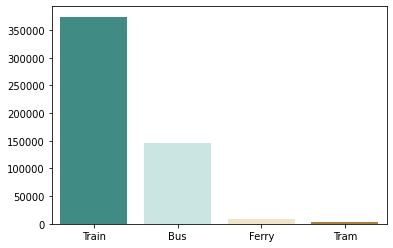

In [7]:
#Total usage - each modes of transport 
tol_plot = income_tol.drop(["Total"], axis=1)
sns.barplot(data= tol_plot, palette= "BrBG_r")

* ***Interpretation:*** Train service has the largest number of passengers across all income groups (> 350000 in total)

We also plot to see the number of each transport uses spreading across all the income groups.

In [8]:
# Transport usage per income group
temp = df_income.drop(["Class", "Total"], axis=1)
temp["Income Groups"] = temp.index
melted = pd.melt(temp, id_vars = "Income Groups", var_name="Transport Types")

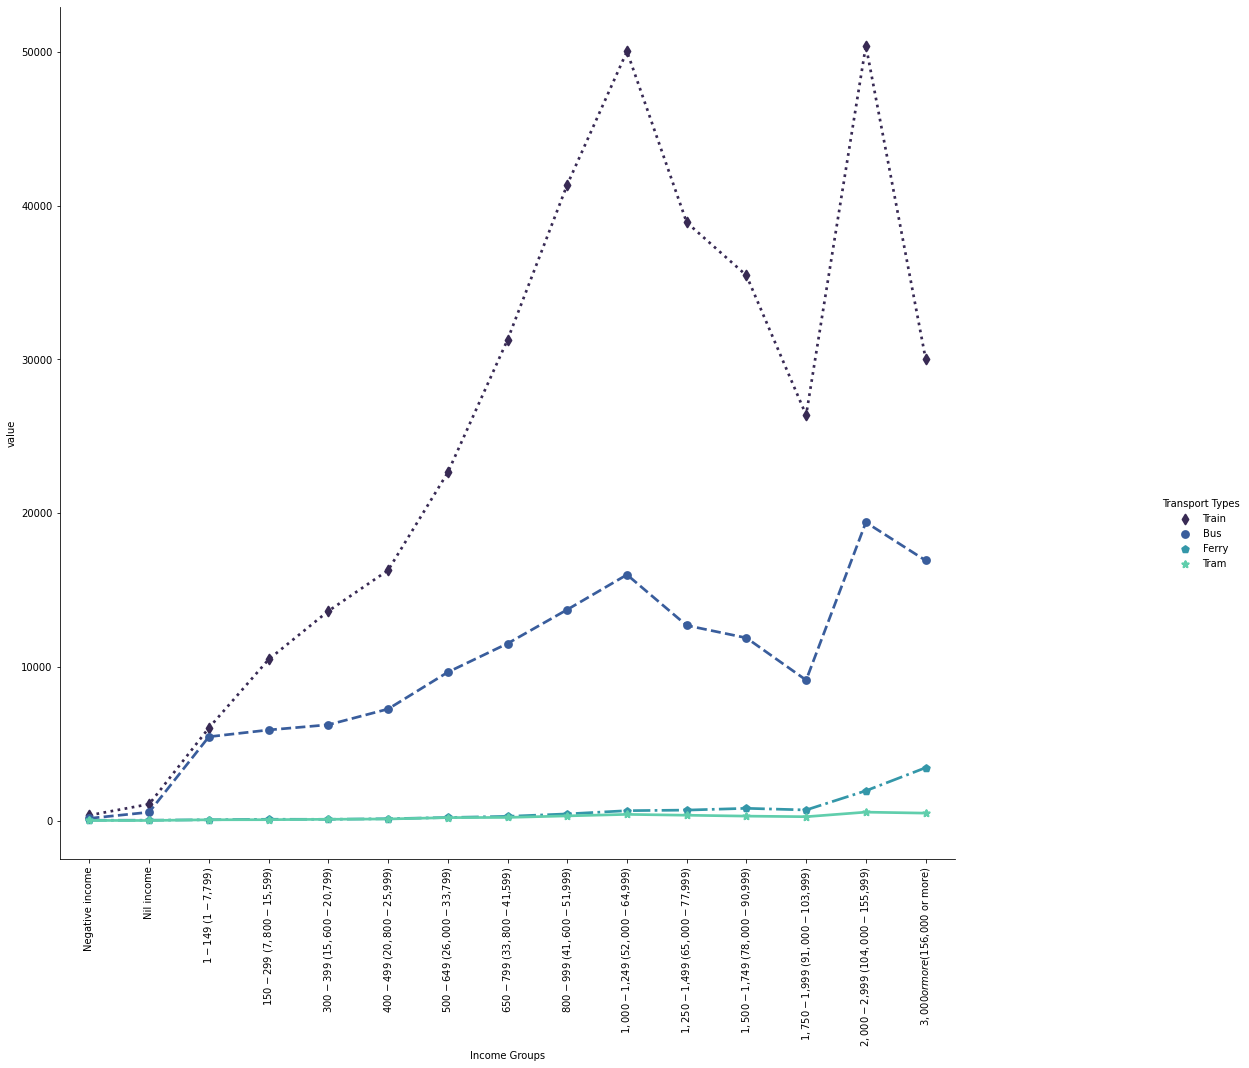

In [9]:
sns_plot = sns.catplot(x="Income Groups", y="value", markers=["d", "o", "p", "*"], 
                       linestyles=["dotted", "dashed", "dashdot", "solid"],
                       kind="point", hue= "Transport Types", data= melted,
                       palette = "mako")
sns_plot.fig.set_size_inches(20,14)
sns_plot.set_xticklabels(rotation = 90)

*Interpretation:* <br><br>
🚆 Train is the most utilized mode of transport overall as well as in virtually every income group, with a peak of over 50000 customers in the income groups 52000-64999(per year) and 104000-155999 (per year). The trend line mostly follows an increasing direction except for a drop in the income groups earning between 65000 and 103999. <br>
🚍 Bus is the second most utilized mode of transport overall with a very similar trend as train data, despite the total usage being less than half the tally of train commuters. There is a slump between income groups of 65000 and 103999 before peaking at the group 104000-155999. <br>
🚋⛴️ Tram and ferry usage are much less frequent than the aforementioned two modes of transport, but both follow a similar trend where the higher the income, the higher the usage. <br>
💸 People with negative income barely uses public transport.

### Percentage of each mode of transport used per income group

In [10]:
df_income["TRAIN"] = (df_income.Train*100)/df_income.Total
df_income["BUS"] = (df_income.Bus*100)/df_income.Total
df_income["FERRY"] = (df_income.Ferry*100)/df_income.Total
df_income["TRAM"] = (df_income.Tram*100)/df_income.Total

<AxesSubplot:title={'center':'Percentage of Transport Uses'}, ylabel='Income Groups'>

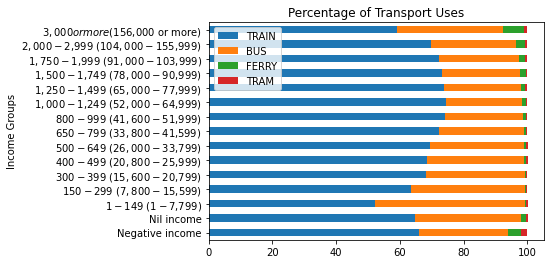

In [11]:
df = df_income.drop(["Train", "Bus", "Ferry", "Tram", "Total", "Class"], axis=1)
df['Income Groups'] = df.index
df.plot(x = "Income Groups", kind = 'barh', stacked = True, title = 'Percentage of Transport Uses')

* ***Interpretation:*** Train is, by a mile, the most popular transport service for all income groups, making up over half the total transport usage for most income groups. It is followed by bus, ferry and tram in order, in every income group. Another interesting finding is ferry and tram usage, the least common modes of transport, increases as income increases.
<br><br>
 These four features could be used to build a model which is to predict the income class (0 and 1).

In [12]:
df_income.drop(["TRAIN", "BUS", "FERRY", "TRAM"], axis= 1, inplace = True)

## Model Building

In [13]:
set(df_income['Class'])

{0, 1}

There are two classes: 0 and 1 
* 0 is stand for the low income earner 
* 1 represented for the high income earner

### Logistic Regression

**Train and Test Sets Splitting**

In [14]:
# Split the data into training (50%) and testing data (50%) and use random_state is 7
train,test = train_test_split(df_income, test_size=0.5, random_state=7)
print(train.shape)
print(test.shape)

(7, 6)
(8, 6)


In [15]:
# Getting input data and targets for building prediction model:
X_train = train.drop(['Total', 'Class'], axis = 1)
y_train = train['Class']
X_test = test.drop(['Total', 'Class'], axis = 1)
y_test = test['Class']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print(X_train.head(2))
print(y_train.head(2))

X_train shape: (7, 4)
y_train shape: (7,)
X_test shape: (8, 4)
y_test shape: (8,)
                                               Train    Bus Ferry Tram
INCP Total Personal Income: weekly (annually)                         
$2,000-$2,999 ($104,000-$155,999)              50401  19397  1940  550
$650-$799 ($33,800-$41,599)                    31266  11515   275  206
INCP Total Personal Income: weekly (annually)
$2,000-$2,999 ($104,000-$155,999)    1
$650-$799 ($33,800-$41,599)          0
Name: Class, dtype: int64


In [16]:
# Training Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [17]:
# Do predictions on test set
y_pred_train= model.predict(X_train)
y_pred_test= model.predict(X_test)
print(y_pred_train)
print(y_pred_test)

[1 0 1 0 0 1 0]
[1 0 1 0 1 1 0 1]


In [18]:
# Evaluate the performance of your trained model
print("Accuracy score on training test:", accuracy_score(y_train,y_pred_train))
print("Accuracy score on testing test:", accuracy_score(y_test,y_pred_test))

Accuracy score on training test: 1.0
Accuracy score on testing test: 0.75


In [19]:
# list of accuracy score of test set
test_scores = []
test_scores.append(accuracy_score(y_test,y_pred_test))

* <i>Comment:</i> The accuracy score is 0.75 which indicates a well-built model. However, since the dataset is small, the training accuracy score reaching 1.0 may indicate overfitting.

### Confusion matrix

In [20]:
print ("Confusion matrix on test set:")
print(confusion_matrix(y_test,y_pred_test))

Confusion matrix on test set:
[[3 2]
 [0 3]]


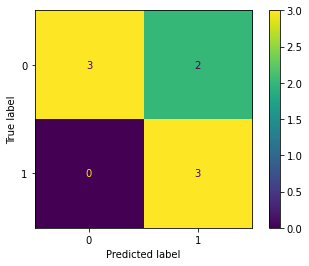

In [21]:
plot_confusion_matrix(model, X_test, y_test)

* <i>Comment:</i> There are two false predictions of class 1 (high income) where they are actually class 0 (low income). Therefore, this model might predict incorrectly the low income group based on the number of transport uses.

In [22]:
acc_scores = []
for i in range(1,5):
    clf = LogisticRegression(max_iter=1000)
    rfe = RFE(estimator =clf, n_features_to_select=i)
    #training model
    rfe.fit(X_train, y_train)
    #predicting on test set 
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    print ("Acc on test set using", i, "feature: ", acc_score)
    print ("Feature which have been chosen:", X_train.columns[rfe.support_])
    print("")
    # append to the list 
    acc_scores.append(acc_score)

Acc on test set using 1 feature:  1.0
Feature which have been chosen: Index(['Ferry'], dtype='object')

Acc on test set using 2 feature:  1.0
Feature which have been chosen: Index(['Ferry', 'Tram'], dtype='object')

Acc on test set using 3 feature:  0.75
Feature which have been chosen: Index(['Bus', 'Ferry', 'Tram'], dtype='object')

Acc on test set using 4 feature:  0.75
Feature which have been chosen: Index(['Train', 'Bus', 'Ferry', 'Tram'], dtype='object')



### RFE

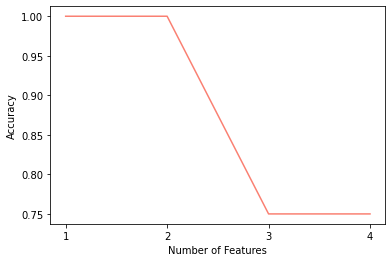

In [23]:
# Plotting the accuracy number
plotting = plt.plot(range(1, X_train.shape[1]+1), acc_scores, color= "salmon")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, 5 , step=1))
plt.show()

* <i>Comment:</i> Using 2 features in ferry and tram usage undoubtedly means precise income group prediction, while adding bus and train into the model, its accuracy score is 0.75, which is also quite good. To avoid building an overfitting model, we will choose the model with four features instead of two.

<b> Cross Validation Testing 

In [24]:
X= df_income.drop(["Total", "Class"], axis= 1)
y= df_income["Class"]

In [25]:
lr = LogisticRegression(max_iter=1000)
scores = cross_val_score(lr, X, y, scoring='accuracy', cv=5)
print('Accuracy range for Logistic Regression: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for Logistic Regression: [0.3333, 1.0000]; mean: 0.8000; std: 0.2667



### K-Nearest Neighbours Classifier

**Train and Test Sets Splitting**

In [26]:
# choosing the nearest 3 neighbours
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [27]:
# do prediction
train_pred = clf_knn.predict(X_train)
test_pred = clf_knn.predict(X_test)

In [28]:
print("Accuracy of the train set:", accuracy_score(y_train, train_pred))
print("Accuracy of the test set:", accuracy_score(y_test, test_pred))
test_scores.append(accuracy_score(y_test, test_pred))

Accuracy of the train set: 0.8571428571428571
Accuracy of the test set: 0.625


<b> Cross Validation Testing

In [29]:
knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn, X, y, scoring='accuracy', cv=5)
print('Accuracy range for K-Nearest Neighbours: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for K-Nearest Neighbours: [0.6667, 1.0000]; mean: 0.7333; std: 0.1333



### Gaussian Naive Bayes

**Train and Test Sets Splitting**

In [31]:
# train the model
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, y_train)

GaussianNB()

In [32]:
# do prediction
train_pred = clf_gnb.predict(X_train)
test_pred = clf_gnb.predict(X_test)

In [33]:
print("Accuracy of the train set:", accuracy_score(y_train, train_pred))
print("Accuracy of the test set:", accuracy_score(y_test, test_pred))
test_scores.append(accuracy_score(y_test, test_pred))

Accuracy of the train set: 1.0
Accuracy of the test set: 0.875


<b>Cross Validation Testing

In [34]:
gnb = GaussianNB()
scores = cross_val_score(gnb, X, y, scoring='accuracy', cv=5)
print('Accuracy range for Gaussian Naive Bayes: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for Gaussian Naive Bayes: [0.3333, 1.0000]; mean: 0.8667; std: 0.2667



### Multi-layer Perceptron

**Train and Test Sets Splitting**

In [35]:
# train the model
clf_nn = MLPClassifier(max_iter=800,solver="lbfgs",activation="tanh",random_state=42)
clf_nn.fit(X_train, y_train)

MLPClassifier(activation='tanh', max_iter=800, random_state=42, solver='lbfgs')

In [36]:
# do prediction
train_pred = clf_nn.predict(X_train)
test_pred = clf_nn.predict(X_test)

In [37]:
print("Accuracy of the train set:", accuracy_score(y_train, train_pred))
print("Accuracy of the test set:", accuracy_score(y_test, test_pred))
test_scores.append(accuracy_score(y_test, test_pred))

Accuracy of the train set: 1.0
Accuracy of the test set: 0.75


**Cross Validation Testing**

In [38]:
nn =  MLPClassifier(max_iter=800, solver="lbfgs",activation="tanh",random_state=42)
scores = cross_val_score(nn, X, y, scoring='accuracy', cv=5)
print('Accuracy range for Gaussian Naive Bayes: [%.4f, %.4f]; mean: %.4f; std: %.4f\n'
      % (scores.min(), scores.max(), scores.mean(), scores.std()))
test_scores.append(scores.mean())

Accuracy range for Gaussian Naive Bayes: [0.0000, 1.0000]; mean: 0.6000; std: 0.3266



### Choosing the Best Model for the Dataset

In [39]:
# dataframe of accuracy scores
models = ["LR_Split", "LR_CV", "KNN_Split", "KNN_CV", "GNB_Split",
         "GNB_CV", "MLP_Split", "MLP_CV"]
df_acc = pd.DataFrame(models, columns=["Model Type"])
df_acc["Accuracy"] = test_scores
df_acc.head(2)

,Model Type,Accuracy
0,LR_Split,0.75
1,LR_CV,0.80


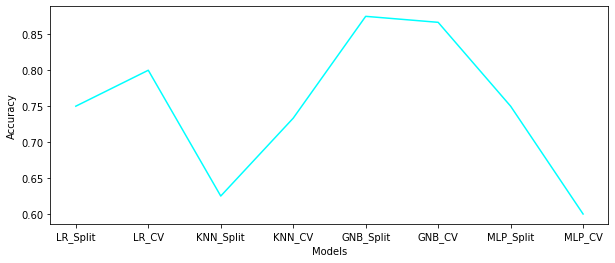

In [40]:
# Plotting the accuracy number
plt.figure (figsize = (10,4))
plt.plot(df_acc["Model Type"], df_acc["Accuracy"], color= "aqua")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

* ***Interpretation:*** We could see the Gaussian Naive Bayes model when using train test splitting is the most accurate prediction within all the models he have built so far, which the accuracy score approaching 0.87, followed by the Gaussian Naive Bayes model using the cross validation method. Therefore, the best model to predict the income group based on the uses of transport is the Gaussian Naive Bayes model.